In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

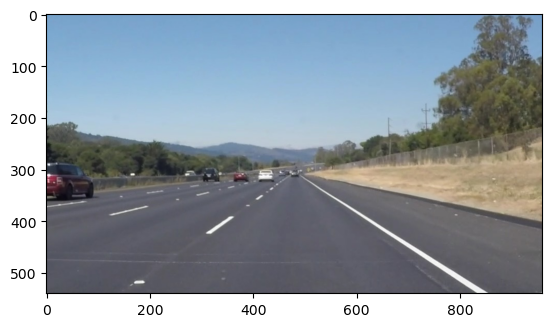

In [7]:
img = plt.imread('solidWhiteRight.jpg')
plt.imshow(img)

In [3]:
def toGray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

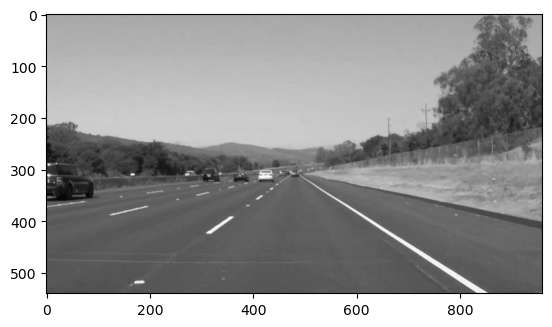

In [8]:
gray = toGray(img)
plt.imshow(gray, cmap='gray')

In [9]:
def findEdges(img):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    return cv2.Canny(blur, 50, 150)

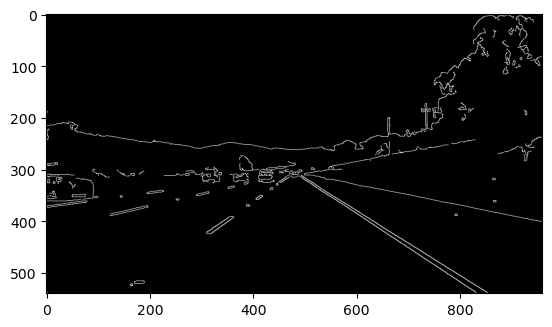

In [10]:
edges = findEdges(gray)
plt.imshow(edges, cmap='gray')

# Region of interest

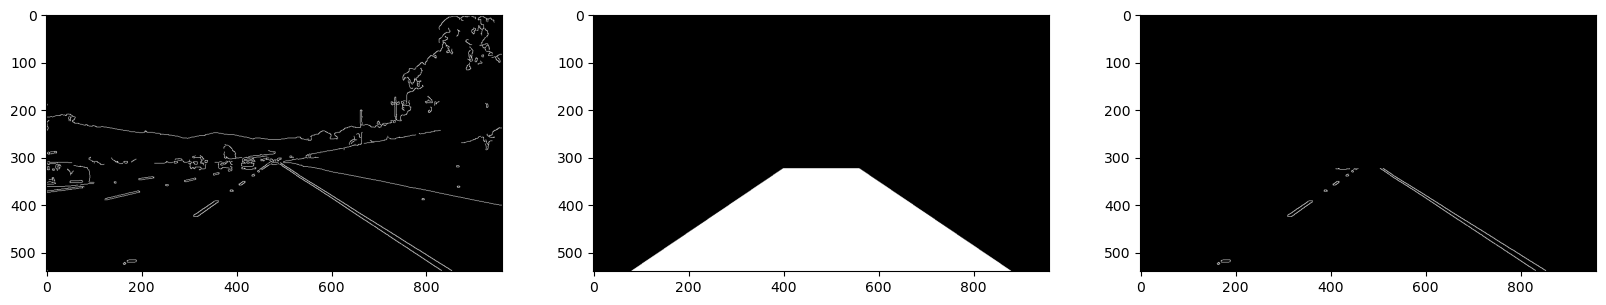

In [11]:
mask = np.zeros_like(edges)
vert = np.array(
    [
        [
        (edges.shape[1]/12, edges.shape[0]),
        (edges.shape[1]*5/12, edges.shape[0]*15/25),
        (edges.shape[1]*7/12, edges.shape[0]*3/5),
        (edges.shape[1]*11/12, edges.shape[0])
        ]
    ], dtype=np.int32
)
cv2.fillPoly(mask, vert, 255)
masked = cv2.bitwise_and(edges, mask)

#visualize
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
ax0.imshow(edges, cmap='gray')
ax1.imshow(mask, cmap='gray')
ax2.imshow(masked, cmap='gray')

In [12]:
def roi(img):
    mask = np.zeros_like(img)
    vert = np.array(
    [
        [
        (img.shape[1]/12, img.shape[0]),
        (img.shape[1]*5/12, img.shape[0]*3/5),
        (img.shape[1]*7/12, img.shape[0]*3/5),
        (img.shape[1]*11/12, img.shape[0])
        ]
    ], dtype=np.int32
    )
    cv2.fillPoly(mask, vert, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

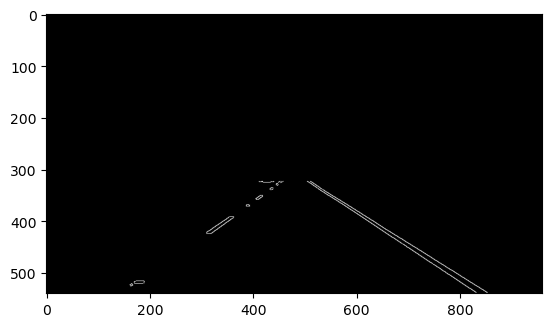

In [13]:
masked = roi(edges)
plt.imshow(masked, cmap='gray')

# Hough Lines
## input : Masked edges image
## output : Array of possible lines

In [14]:
def houghLines(img):
    #  cv2.HoughLinesP(img, resolution of rho, resolution of theta, threshold, MinLineLength ,MaxLineGap )
    return cv2.HoughLinesP(img, 3.5, np.pi/180, 10, 5, 10)

lines = houghLines(masked)
print(lines)
print(lines.shape)

[[[719 464 742 480]]

 [[685 433 752 475]]

 [[813 526 829 537]]

 [[656 423 666 429]]

 [[310 423 354 393]]

 [[336 413 353 400]]

 [[631 399 664 421]]

 [[772 488 788 497]]

 [[546 347 566 359]]

 [[554 356 566 363]]

 [[665 429 681 439]]

 [[696 449 706 455]]

 [[517 327 527 335]]

 [[424 326 434 326]]

 [[705 455 715 461]]]
(15, 1, 4)


In [17]:
def drawLines(img, lines):
    lines_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(lines_img, (x1, y1), (x2,y2), [255, 0, 0], 10)
    return lines_img

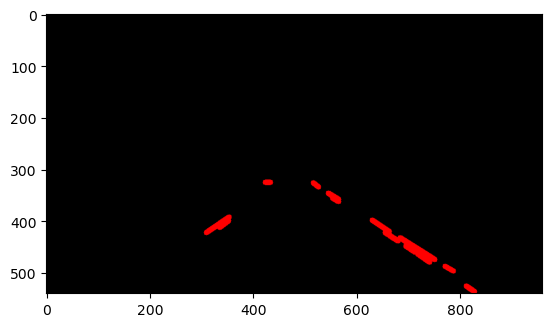

In [18]:
lined_img = drawLines(masked, lines)
plt.imshow(lined_img)

In [19]:
def formulate_lanes(lines, img):
    negativeSlopes = []
    positiveSlopes = []

    negativeInter = []
    positiveInter = []

    y_min = img.shape[0]
    y_max = img.shape[0]

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1) / (x2-x1)
            intercept = y2-(slope*x2)

            y_min = min(y1, y2, y_min)

            if slope > 0.0:
                positiveSlopes.append(slope)
                positiveInter.append(intercept)
            elif slope < 0.0:
                negativeSlopes.append(slope)
                negativeInter.append(intercept)

    postitiveSlope = np.mean(positiveSlopes)
    positiveIntercept = np.mean(positiveInter)

    negativeSlope = np.mean(negativeSlopes)
    negativeIntercept = np.mean(negativeInter)
    
    pts = [
        [[0,0,0,0]],
        [[0,0,0,0]]
    ]
    # Positive
    if len(positiveSlopes) > 0:
        x_max = (y_max - positiveIntercept) / postitiveSlope
        x_min = (y_min - positiveIntercept) / postitiveSlope
        pts[0][0] = [x_min, y_min, x_max, y_max]
    # Negative
    if len(negativeSlopes) > 0:
        x_max = (y_max - negativeIntercept) / negativeSlope
        x_min = (y_min - negativeIntercept) / negativeSlope
        pts[1][0] = [x_min, y_min, x_max, y_max]
        
    return np.array(pts, dtype=np.int32)

In [28]:
lanes = formulate_lanes(lines, lined_img)

In [21]:
print(lanes)

[[[506 326 842 540]]

 [[450 326 155 540]]]


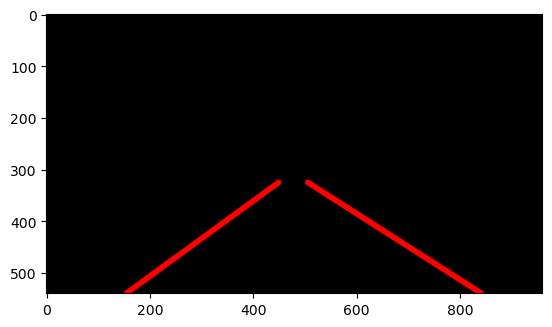

In [22]:
lined_img = drawLines(masked, lanes)
plt.imshow(lined_img)

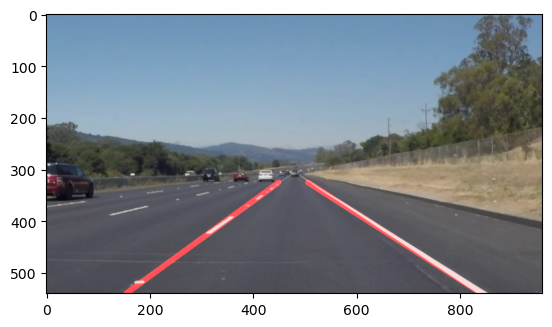

In [24]:
output = cv2.addWeighted(img, 0.9, lined_img, 1, 0)
plt.imshow(output)

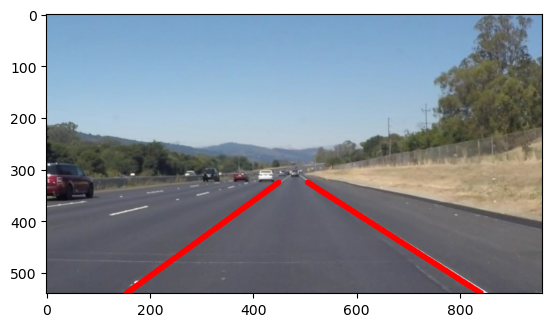

In [27]:
def drawLinesImg(img, lines):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1,y1), (x2,y2), [255,0,0], 10)
    return img
plt.imshow(drawLinesImg(img, lanes));